### Helpers

In [1]:
#Packages for NLP
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import json
import string
import nltk
from nltk.corpus import stopwords
from  nltk import FreqDist
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from textblob import TextBlob
from textblob import Word
from wordcloud import WordCloud, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')
import re
from pylab import *

nlp = spacy.load("en_core_web_sm")

I will use the same functions from EDA notebook - I want to clean the data again before modeling

In [ ]:
# Functions for cleaning

In [3]:
#Define stopwords
punctuation = "".join([symbol for symbol in string.punctuation if symbol not in ["'", '"']])
punctuation += '–'
punctuation += '...'

stopwords_list = stopwords.words('english')
stopwords_list += list(punctuation)
stopwords_list += ['yeah','yea','uh','wo','yo','yeah!','ain\'t','i\'m','ah','ha','aa', 'aaah', 'aah', 
                   'aap','ab', 'abc','ac', 'aha', 'ahah','ahh ahh', 'ahha', 'ahhh',
                    'ahhhh', 'ahhhhh', 'ai','aight', 'aiight','aiyo', 'aiyyo', 'aj','aw','ay',
                   'aww', 'ayy','ayyo', 'ayyy', 'az', 'azz','\'em', 'em','haha','hahahahaha','hah','haa',
                   'hahah', 'hahaha', 'hahahah','one','ooh','oooh','oh','ooo','ot', 'otf', 'otha',
                    'qb','sh', 'sha', 'shabazz', 'shabba', 'shack','ugh',
                    'ughh', 'ugk', 'uhh','uhhh', 'uhhhh', 'uhhuh','uhm', 
                    'uhoh', 'uhuh','vv', 'vvs', 'wa','wit','woo','ya',
                    'yep','ym','yup','zro','yuh','jd', 'je','wow','ii', 'iii', 'it','ima','imma','jr', 'js']

In [4]:
#Checking my list of stopwords
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [5]:
#Function to have a list of words into one block
def concat_songs(list_lyrics):
    combo = ' '.join(lyric for lyric in list_lyrics)
    return combo

In [6]:
def get_tokens(songs, remove_stop_words=True):
    """Splits a string of text into individual words and transform some bad languages"""
    #remove stop words
    stop_words = set(stopwords_list) if remove_stop_words else []
    #tokenize
    words = [x for x in songs.split() if x not in stop_words]
    words = ['Nword' if x in ['nigga', 'niggas','n*gga','n*ggas'] else x for x in words]
    words = ['Fword' if x in ['fuck', 'fucking','fuckin','fuckin\'','fucker','motherfucker','motherfucking','mothafuck', 
                              'mothafucka', 'mothafuckas', 'mothafucker', 'mothafuckers', 'mothafuckin', 'mothafucking',
                             'fuckers', 'motherfuck','mother fuckers','motherfuck', 'motherfucka', 'motherfuckas', 
                              'motherfucker','motherfuckers','motherfuckin','motherfucking'] else x for x in words]
    words = ['Bword' if x in ['bitch', 'bitch ', 'ho','hoes','b*tch','bitches', 'bitchin'] else x for x in words]
    return words

In [7]:
#replace in' with ing and digits - converting some rappers names back
def replace_contraction(list_lyrics):
    result = []
    for lyric in list_lyrics:
        lyric = re.sub(r'[0-9]', '# ',lyric)
        lyric = lyric.replace("# pac","2Pac")
        lyric = lyric.replace("# Pac","2Pac")
        lyric = lyric.replace("# chainz","2Chainz")
        lyric = lyric.replace("# Chainz","2Chainz")
        lyric = lyric.replace("# Savage","21Savage")
        lyric = lyric.replace("# Cent","50Cent")
        result.append(lyric.replace("in\'","ing"))
    return result

In [8]:
def lem_words(list_of_tokens,pos): 
    wrd_list = [Word(word).lemmatize(pos=pos) for word in list_of_tokens]
    # join the individual lemmas into a single string
    return wrd_list

In [9]:
#function to create wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=17 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [10]:
#Function to create correlation heatmap - if necessary
def CorrMtx(df, dropDuplicates = True):

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(12, 8))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)

## Getting dataframes & Cleaning

In [12]:
#Importing big dataframes
df = pd.read_pickle('../Data-Cleaning-EDA/cleaned_full_data.pkl')

In [13]:
print(df.shape)
df.head()

(27110, 22)


,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,...,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,"[years, waitin, hesitatin, make, rap, record, ...","[year, waitin, hesitatin, make, rap, record, p...",234
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,...,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",165
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,...,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,"[harsh, realities, life, taken, toll, even, je...","[harsh, reality, life, take, toll, even, jesus...",460
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,...,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",317
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,...,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",304


In [14]:
#drop some columns before re-cleaning the data
df = df.drop(columns=['Album','Title','duration_ms','tokens','tokens_lemma'])

In [15]:
df.shape #(27510, 17)

(27110, 17)

In [18]:
#Checking if any null values
df.isna().sum()

Artist                 0
popularity             0
num_markets            0
danceability           0
energy                 0
loudness               0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
time_signature         0
Year_release        5895
Cleaned_lyrics         0
duration_mins          0
Count_words            0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27110 entries, 0 to 27513
Data columns (total 17 columns):
Artist              27110 non-null object
popularity          27110 non-null object
num_markets         27110 non-null object
danceability        27110 non-null float64
energy              27110 non-null float64
loudness            27110 non-null float64
speechiness         27110 non-null float64
acousticness        27110 non-null float64
instrumentalness    27110 non-null float64
liveness            27110 non-null float64
valence             27110 non-null float64
tempo               27110 non-null float64
time_signature      27110 non-null object
Year_release        21215 non-null float64
Cleaned_lyrics      27110 non-null object
duration_mins       27110 non-null float64
Count_words         27110 non-null int64
dtypes: float64(11), int64(1), object(5)
memory usage: 3.7+ MB


In [20]:
# get rid of lyrics with less than 25 words - should be taken care already
df.drop(df[df['Cleaned_lyrics'].str.len() < 25].index, inplace=True)

In [21]:
df.shape

(27110, 17)

In [22]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,317
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,304


In [23]:
#remove stop words and create token
df['tokens'] = df.Cleaned_lyrics.apply(lambda x: get_tokens(x))

In [24]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,"[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,"[big, 14, know, Fword, going, know, keep, cand..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,"[harsh, realities, life, taken, toll, even, je..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,317,"[skoob, dray, giving, shoutouts, chorus, well,..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,304,"[beat, beat, y'all, beat, y'all, beat, y'all, ..."


In [25]:
#more words cleaning
df['tokens'] = df.tokens.apply(lambda x: replace_contraction(x))

In [26]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,"[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,"[big, # # , know, Fword, going, know, keep, ca..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,"[harsh, realities, life, taken, toll, even, je..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,317,"[skoob, dray, giving, shoutouts, chorus, well,..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,304,"[beat, beat, y'all, beat, y'all, beat, y'all, ..."


In [27]:
#Lemmatize for nouns
df['lemmatized_lyrics'] = df.tokens.apply(lambda x: lem_words(x,'n'))

In [28]:
#Lemmatize for verbs
df['lemmatized_lyrics'] = df.tokens.apply(lambda x: lem_words(x,'v'))

In [29]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens,lemmatized_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,317,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,304,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ..."


In [30]:
#updating count words columns
df['Count_words'] = df.lemmatized_lyrics.apply(lambda x: len(x))

In [31]:
df['working_lyrics'] = df.lemmatized_lyrics.apply(lambda x: concat_songs(x))

In [32]:
#Checking if there is null values after cleaning
df.isna().sum()

Artist                  0
popularity              0
num_markets             0
danceability            0
energy                  0
loudness                0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
time_signature          0
Year_release         5895
Cleaned_lyrics          0
duration_mins           0
Count_words             0
tokens                  0
lemmatized_lyrics       0
working_lyrics          0
dtype: int64

In [33]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens,lemmatized_lyrics,working_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",big # # know Fword go know keep candy need li...
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,317,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,304,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",beat beat y'all beat y'all beat y'all yes y'al...


## Most frequent words

### All Lyrics

In [ ]:
#Functions to count top words and plots the frequency (from https://github.com/h-parker/commencement-speech-generator/blob/master/nlp-eda.ipynb)

In [34]:
def get_top_n_words(ngram_start, ngram_end, corpus, n=10):
    """
    List the top n words in a vocabulary according to occurrence in corpus.
    """
    vec = CountVectorizer(ngram_range = (ngram_start, ngram_end))
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [35]:
def plot_top_n_ngrams(corpus, n, ngram_start, ngram_end):
    """
    Given corpus, number of top words you want, the range of 
    ngrams you're interested in (eg, just words: start = 1, end=1;
    words & bigrams: start=1, end=2), this function will graph the
    top words/ngrams in your corpus.
    """
    # get top n words
    top_words = get_top_n_words(ngram_start, ngram_end, corpus, n)
    
    # plot top n words
    fig = plt.figure(figsize=(10,6))
    ax = plt.barh([x[0] for x in top_words], [y[1] for y in top_words], 
            align='center', alpha=0.5,color='r')
    plt.title('Distribution of most frequent words')
    plt.xlabel('# times')
    plt.ylabel('Words')



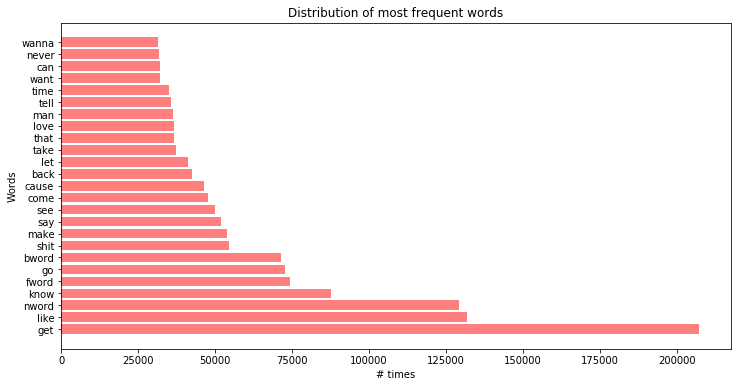

In [36]:
plot_top_n_ngrams(df.working_lyrics, 25, 1, 1)

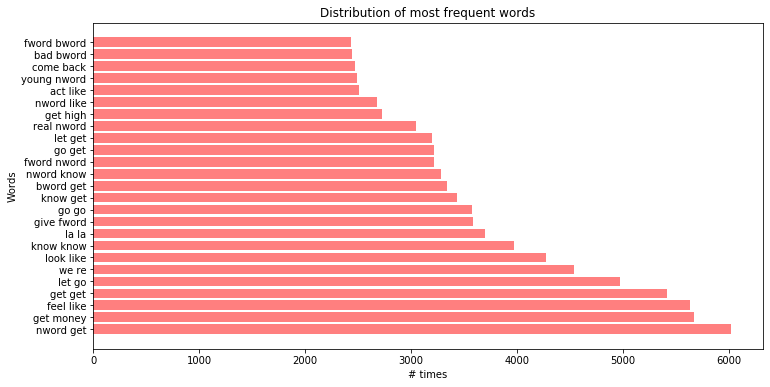

In [37]:
plot_top_n_ngrams(df.working_lyrics, 25, 2, 2)

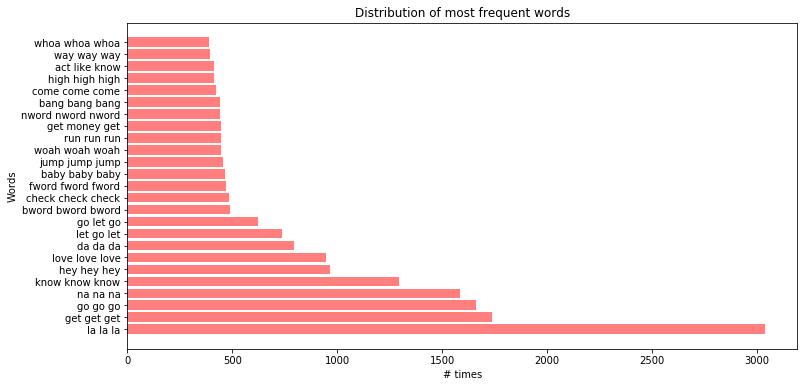

In [38]:
plot_top_n_ngrams(df.working_lyrics, 25, 3, 3)

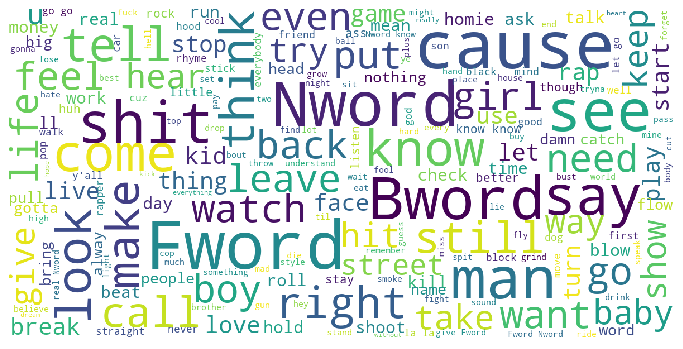

In [46]:
show_wordcloud(list(df.working_lyrics))

## Vectorizing

### TF IDF

In [39]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens,lemmatized_lyrics,working_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",big # # know Fword go know keep candy need li...
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,317,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,304,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",beat beat y'all beat y'all beat y'all yes y'al...


In [40]:
len(df) #27110

27110

after preparing the list of words - Let's get the words into vectors

In [41]:
#max_df --> ignore words that appear in 95% of the songs 
#ignores words that occur in fewer than 25 songs - use my created stopword list
# I am not interested in more than 1k features
vectorizer = TfidfVectorizer(max_df=0.95, max_features=1000,
                             min_df=25, stop_words=stopwords_list,
                             use_idf=True, ngram_range=(1, 3))

In [ ]:
#using TF-IDF to vectorize 
lyrics_tfidf = vectorizer.fit_transform(df['working_lyrics'])

In [42]:
#Checking the shape of my TF-IDF vectorizer
print(lyrics_tfidf.shape)

In [47]:
print(vectorizer.get_feature_names())

Transform TF-IDF vectors into a DataFrame

In [ ]:
#TF-IDF vectorizer into DF
vect_df = pd.DataFrame(lyrics_tfidf.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
#Having a look - checking for length and null values
vect_df.sample(10)

In [ ]:
vect_df.shape #(27110, 1000)

In [ ]:
vect_df.isna().sum()

### Count Vector

In [49]:
count_vectorizer = CountVectorizer(max_df=0.9, max_features=1000,
                             min_df=25, stop_words=stopwords_list,
                             ngram_range=(1, 3))

['act', 'act like', 'action', 'ahead', 'aim', 'air', 'album', 'alive', 'alone', 'along', 'already', 'alright', 'always', 'another', 'answer', 'anybody', 'anything', 'arm', 'around', 'ask', 'ass', 'ass nword', 'attention', 'away', 'aye', 'baby', 'baby baby', 'baby girl', 'back', 'bad', 'bad bword', 'bag', 'ball', 'band', 'bang', 'bang bang', 'bank', 'bar', 'battle', 'bear', 'beat', 'beautiful', 'become', 'bed', 'beef', 'begin', 'behind', 'believe', 'bend', 'benz', 'best', 'bet', 'better', 'big', 'bigger', 'bill', 'bird', 'bite', 'black', 'blame', 'blast', 'blaze', 'bleed', 'bless', 'blind', 'block', 'blood', 'blow', 'blue', 'blunt', 'body', 'bomb', 'bone', 'boo', 'book', 'boom', 'booty', 'boss', 'bottle', 'bottom', 'bounce', 'bout', 'bow', 'box', 'boy', 'boys', 'brain', 'brand', 'brand new', 'bread', 'break', 'breath', 'breathe', 'brick', 'bricks', 'bring', 'bro', 'brother', 'brothers', 'brown', 'buck', 'build', 'bullets', 'bullshit', 'bump', 'burn', 'bus', 'business', 'bust', 'buy', 'b

In [50]:
#using counter to vectorize 
lyrics_count_vect = count_vectorizer.fit_transform(df['working_lyrics'])

(27110, 1000)


In [51]:
#Checking the shape of my counter vectorizer
print(lyrics_count_vect.shape)

(27110, 1000)


In [52]:
print(count_vectorizer.get_feature_names())

['act', 'act like', 'action', 'ahead', 'aim', 'air', 'album', 'alive', 'alone', 'along', 'already', 'alright', 'always', 'another', 'answer', 'anybody', 'anything', 'arm', 'around', 'ask', 'ass', 'ass nword', 'attention', 'away', 'aye', 'baby', 'baby baby', 'baby girl', 'back', 'bad', 'bad bword', 'bag', 'ball', 'band', 'bang', 'bang bang', 'bank', 'bar', 'battle', 'bear', 'beat', 'beautiful', 'become', 'bed', 'beef', 'begin', 'behind', 'believe', 'bend', 'benz', 'best', 'bet', 'better', 'big', 'bigger', 'bill', 'bird', 'bite', 'black', 'blame', 'blast', 'blaze', 'bleed', 'bless', 'blind', 'block', 'blood', 'blow', 'blue', 'blunt', 'body', 'bomb', 'bone', 'boo', 'book', 'boom', 'booty', 'boss', 'bottle', 'bottom', 'bounce', 'bout', 'bow', 'box', 'boy', 'boys', 'brain', 'brand', 'brand new', 'bread', 'break', 'breath', 'breathe', 'brick', 'bricks', 'bring', 'bro', 'brother', 'brothers', 'brown', 'buck', 'build', 'bullets', 'bullshit', 'bump', 'burn', 'bus', 'business', 'bust', 'buy', 'b

Create a DF with the features from counter vect

In [57]:
#Counter vectorizer into DF
vect_count_df = pd.DataFrame(lyrics_count_vect.toarray(), columns=count_vectorizer.get_feature_names())

In [58]:
vect_count_df.sample(10)

,act,act like,action,ahead,aim,air,album,alive,alone,along,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
21935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25338,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2439,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,3,1,0
17833,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5159,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13311,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5415,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Transformation SVD and LSA

In [59]:
from sklearn.decomposition import TruncatedSVD
# init svd
svd = TruncatedSVD(n_components=500, random_state=17)
lsa = make_pipeline(svd, Normalizer(copy=False))

In [60]:
# run svd
lyrics_lsa = lsa.fit_transform(lyrics_tfidf)

In [61]:
sum(svd.explained_variance_ratio_[0:500])

0.7520764726792715

In [62]:
lyrics_lsa.shape

(27110, 500)

In [ ]:
#Trying to understand the components

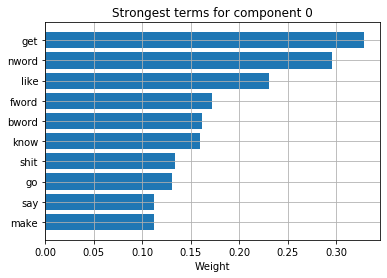

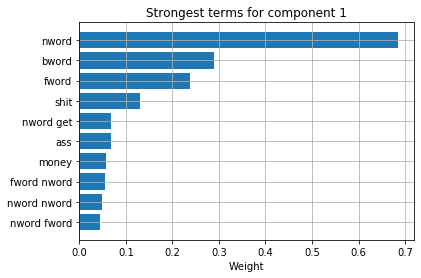

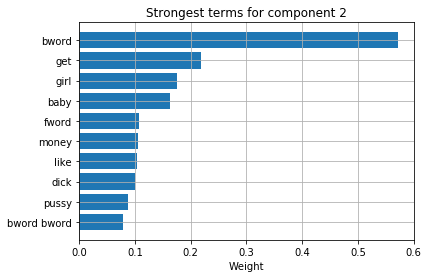

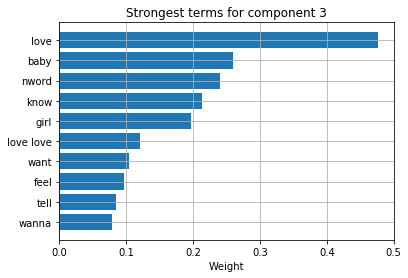

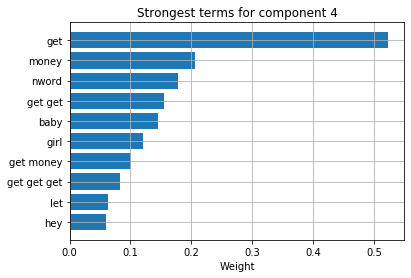

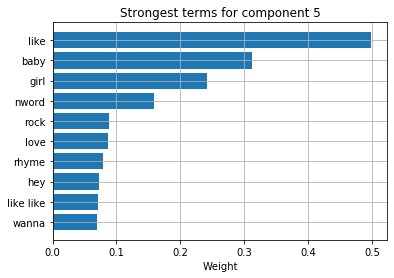

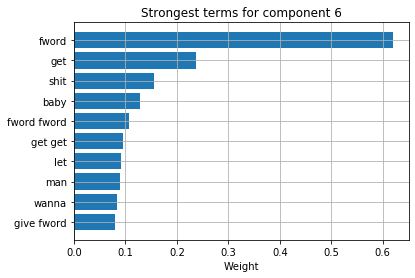

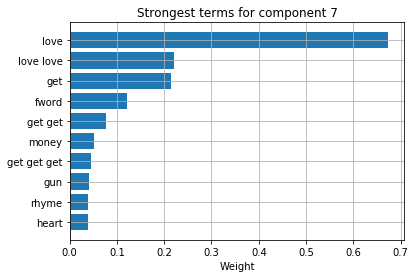

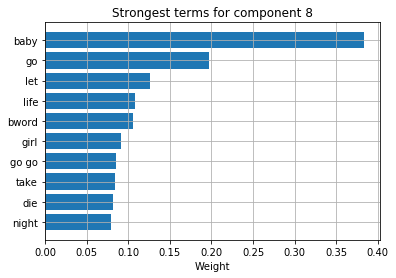

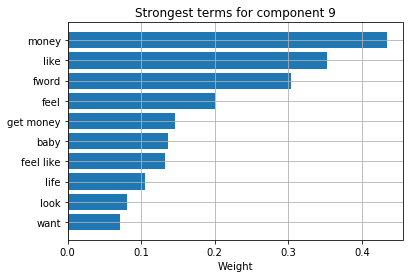

In [63]:
# taken from https://github.com/chrisjmccormick/LSA_Classification/blob/master/inspect_LSA.py
for compNum in range(0, 10):

    comp = svd.components_[compNum]
    feat_names = vectorizer.get_feature_names()
    
    # Sort the weights in the first component, and get the indeces
    indices = np.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indices.reverse()
    
    # Grab the top 10 terms which have the highest weight in this component.        
    terms = [feat_names[weightIndex] for weightIndex in indices[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indices[0:10]]    
   
    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = arange(10) + .5    # the bar centers on the y axis
    
    figure(compNum)
    barh(positions, weights, align='center')
    yticks(positions, terms)
    xlabel('Weight')
    title('Strongest terms for component %d' % (compNum))
    grid(True)
    show()

## Latent dirichlet allocation

### from https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [379]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
# from sklearn.datasets import fetch_20newsgroups

n_samples = 27110
n_features = 1000
n_components = 10
n_top_words = 25


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [383]:



# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

# print("Loading dataset...")
# t0 = time()
# dataset = fetch_20newsgroups(shuffle=True, random_state=1,
#                              remove=('headers', 'footers', 'quotes'))
data_samples = df['working_lyrics']
# print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=25,
                                   max_features=n_features,
                                   stop_words=stopwords_list,ngram_range=(1, 3))
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=25,
                                max_features=n_features,
                                stop_words=stopwords_list,ngram_range=(1, 3))
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# # Fit the NMF model
# print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
#       "n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
# t0 = time()
# nmf = NMF(n_components=n_components, random_state=1,
#           alpha=.1, l1_ratio=.5).fit(tfidf)
# print("done in %0.3fs." % (time() - t0))

# print("\nTopics in NMF model (Frobenius norm):")
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# print_top_words(nmf, tfidf_feature_names, n_top_words)

# # Fit the NMF model
# print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
#       "tf-idf features, n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
# t0 = time()
# nmf = NMF(n_components=n_components, random_state=1,
#           beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
#           l1_ratio=.5).fit(tfidf)
# print("done in %0.3fs." % (time() - t0))

# print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
#try tf-idf for LDA
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extracting tf-idf features for NMF...
done in 52.482s.
Extracting tf features for LDA...
done in 53.972s.

Fitting LDA models with tf features, n_samples=27110 and n_features=1000...
done in 209.579s.

Topics in LDA model:
Topic #0: bword fword get like nword shit ass la pussy dick bad say pull la la go call know bword get money la la la tell talk put look lil
Topic #1: love money get gon see wanna know make god get money nword let love love tryna need everything lil take really much gangsta keep way like say
Topic #2: get go baby girl high smoke get get go go like need tonight take roll let know wanna get high good crazy tell say time cause weed come
Topic #3: like get time make see take life live us back cause come keep know rap go world black try rhyme put never man leave new
Topic #4: come get like boy bang da feel jump hot hit back cause head round wild boom new go make ice bone feel like bang bang wanna come come
Topic #5: get like money make hey look know cause tell way say man 

In [385]:
len(tf_feature_names)

1000

### v1

In [73]:
import gensim
from gensim.models import LdaMulticore 
from gensim import corpora, models
from gensim.sklearn_api import TfIdfTransformer

# get all of the words in our corpus & create a bag of words
dictionary = gensim.corpora.Dictionary(df['lemmatized_lyrics'])
bow_corpus = [dictionary.doc2bow(doc) for doc in df['lemmatized_lyrics']]

# get the tf-idf (gensim-style, using their implementation of 
# sklearn's tf-idf model) of our data
model = TfIdfTransformer()
corpus_tfidf = model.fit_transform(bow_corpus)

# use LDA to get 10 topics to split up our descriptions into
lda_model_tfidf = LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.002*"i’m" + 0.001*"don’t" + 0.001*"Nword" + 0.001*"it’s" + 0.001*"ain’t" + 0.001*"Bword" + 0.001*"Fword" + 0.001*"shit" + 0.001*"feel" + 0.001*"love"
Topic: 1 Word: 0.002*"Nword" + 0.001*"Bword" + 0.001*"Fword" + 0.001*"baby" + 0.001*"shit" + 0.001*"love" + 0.001*"'cause" + 0.001*"man" + 0.001*"money" + 0.001*"gon'"
Topic: 2 Word: 0.001*"Nword" + 0.001*"i’m" + 0.001*"love" + 0.001*"Fword" + 0.001*"la" + 0.001*"Bword" + 0.001*"baby" + 0.001*"girl" + 0.001*"money" + 0.001*"cause"
Topic: 3 Word: 0.003*"Nword" + 0.002*"Bword" + 0.002*"Fword" + 0.001*"love" + 0.001*"baby" + 0.001*"shit" + 0.001*"cause" + 0.001*"money" + 0.001*"wanna" + 0.001*"life"
Topic: 4 Word: 0.001*"Nword" + 0.001*"Bword" + 0.001*"girl" + 0.000*"Fword" + 0.000*"money" + 0.000*"hey" + 0.000*"baby" + 0.000*"wanna" + 0.000*"i’m" + 0.000*"love"


In [74]:
for index, score in sorted(lda_model_tfidf[bow_corpus[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8960294127464294	 
Topic: 0.003*"Nword" + 0.002*"Bword" + 0.002*"Fword" + 0.001*"love" + 0.001*"baby" + 0.001*"shit" + 0.001*"cause" + 0.001*"money" + 0.001*"wanna" + 0.001*"life"

Score: 0.10027754306793213	 
Topic: 0.001*"Nword" + 0.001*"Bword" + 0.001*"girl" + 0.000*"Fword" + 0.000*"money" + 0.000*"hey" + 0.000*"baby" + 0.000*"wanna" + 0.000*"i’m" + 0.000*"love"


In [75]:
lda_categories = [lda_model_tfidf[bow_corpus[i]][0][0] for i in range(0, len(bow_corpus))]

In [76]:
#Lyrics join(pd.Series(lda_categories))
lda_df = pd.concat([df, pd.Series(lda_categories, name='lda_category')], axis=1, join='outer')

In [77]:
lda_df.isna().sum()

Artist                400
popularity            400
num_markets           400
danceability          400
energy                400
loudness              400
speechiness           400
acousticness          400
instrumentalness      400
liveness              400
valence               400
tempo                 400
time_signature        400
Year_release         6295
Cleaned_lyrics        400
duration_mins         400
Count_words           400
tokens                400
lemmatized_lyrics     400
working_lyrics        400
lda_category          400
dtype: int64

In [78]:
lda_df.lda_category.value_counts()

3.0    25132
1.0      802
0.0      699
2.0      477
Name: lda_category, dtype: int64

In [79]:
lda_df.head(25)

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens,lemmatized_lyrics,working_lyrics,lda_category
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.1610,0.001720,0.000020,0.0648,...,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234.0,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...,3.0
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.0490,0.008290,0.000000,0.1820,...,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165.0,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",big # # know Fword go know keep candy need li...,3.0
2,Big Pun,57,79,0.724,0.887,-7.076,0.3930,0.134000,0.000000,0.1120,...,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460.0,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...,3.0
3,Das EFX,22,78,0.791,0.783,-10.470,0.4160,0.293000,0.000000,0.2950,...,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,317.0,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...,1.0
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.2320,0.019300,0.000107,0.3950,...,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,304.0,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",beat beat y'all beat y'all beat y'all yes y'al...,3.0
5,N.O.R.E.,12,79,0.555,0.650,-5.716,0.4050,0.012900,0.000000,0.4260,...,91.071,4,NaN,hey yo the same og yo thats my shit switch cds...,4.49,361.0,"[hey, og, thats, shit, switch, cds, threw, nas...","[hey, og, thats, shit, switch, cds, throw, nas...",hey og thats shit switch cds throw nas shit wh...,3.0
6,Pharoahe Monch,26,1,0.602,0.677,-4.964,0.1660,0.001740,0.000000,0.1520,...,85.313,4,2006.0,pushin' pushin' pushin' pushin' i live my li...,2.87,148.0,"[pushing, pushing, pushing, pushing, live, lif...","[push, push, push, push, live, life, day, time...",push push push push live life day time hold he...,3.0
7,Cypress Hill,22,79,0.790,0.561,-8.044,0.3490,0.008610,0.000018,0.0909,...,97.369,4,2006.0,i'm in the city of sunshine but don't be foole...,4.08,343.0,"[city, sunshine, fooled, say, never, rains, te...","[city, sunshine, fool, say, never, rain, tell,...","city sunshine fool say never rain tell ""that t...",3.0
8,Classified,24,78,0.535,0.897,-4.275,0.2740,0.011200,0.000000,0.2140,...,77.834,4,2018.0,brebrebreak break i'm that kid in the corner a...,3.40,312.0,"[brebrebreak, break, kid, corner, fucked, wann...","[brebrebreak, break, kid, corner, fuck, wanna,...",brebrebreak break kid corner fuck wanna gonna ...,0.0
9,Nicki Minaj,34,4,0.650,0.823,-2.238,0.0669,0.407000,0.000000,0.0622,...,132.004,4,2012.0,we are going up in flames one more night for u...,5.10,253.0,"[going, flames, night, us, burn, brighter, goi...","[go, flame, night, us, burn, brighter, go, fla...",go flame night us burn brighter go flame last ...,3.0


## Clustering 1 - with LDA

In [80]:
# Required packages
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import datasets

In [81]:
lda_df.columns

Index(['Artist', 'popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'Year_release',
       'Cleaned_lyrics', 'duration_mins', 'Count_words', 'tokens',
       'lemmatized_lyrics', 'working_lyrics', 'lda_category'],
      dtype='object')

In [82]:
features = lda_df[['popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature',
       'duration_mins', 'Count_words','lda_category']]

In [83]:
features.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_mins,Count_words,lda_category
0,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,4.43,234.0,3.0
1,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2.61,165.0,3.0
2,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,4.25,460.0,3.0
3,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,3.23,317.0,1.0
4,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,3.35,304.0,3.0


In [94]:
#Covert columns in object to float
features['popularity'] = features['popularity'].astype('float64')

In [96]:
features['num_markets'] = features['num_markets'].astype('float64')

In [97]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27510 entries, 0 to 27513
Data columns (total 15 columns):
popularity          27110 non-null float64
num_markets         27110 non-null float64
danceability        27110 non-null float64
energy              27110 non-null float64
loudness            27110 non-null float64
speechiness         27110 non-null float64
acousticness        27110 non-null float64
instrumentalness    27110 non-null float64
liveness            27110 non-null float64
valence             27110 non-null float64
tempo               27110 non-null float64
time_signature      27110 non-null object
duration_mins       27110 non-null float64
Count_words         27110 non-null float64
lda_category        27110 non-null float64
dtypes: float64(14), object(1)
memory usage: 3.4+ MB


In [99]:
#Checking for null value due to topic attributes
features.isna().sum()

popularity          400
num_markets         400
danceability        400
energy              400
loudness            400
speechiness         400
acousticness        400
instrumentalness    400
liveness            400
valence             400
tempo               400
time_signature      400
duration_mins       400
Count_words         400
lda_category        400
dtype: int64

In [100]:
features.dropna(inplace=True)

In [101]:
features.isna().sum()

popularity          0
num_markets         0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
duration_mins       0
Count_words         0
lda_category        0
dtype: int64

In [102]:
len(features)

26710

In [103]:
#Create dummies variables
ts_dummies = pd.get_dummies(features['time_signature'], prefix='timsign', drop_first=True)
lda_dummies = pd.get_dummies(features['lda_category'], prefix='lda', drop_first=True)

In [104]:
#Remove the original columns
features = features.drop(['time_signature','lda_category'], axis=1)

In [105]:
features.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,Count_words
0,24.0,79.0,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4.43,234.0
1,78.0,79.0,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,2.61,165.0
2,57.0,79.0,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4.25,460.0
3,22.0,78.0,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,3.23,317.0
4,11.0,77.0,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,3.35,304.0


In [106]:
features = pd.concat([features, ts_dummies, lda_dummies], axis=1)
features.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,Count_words,timsign_1,timsign_3,timsign_4,timsign_5,lda_1.0,lda_2.0,lda_3.0
0,24.0,79.0,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4.43,234.0,0,0,1,0,0,0,1
1,78.0,79.0,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,2.61,165.0,0,0,1,0,0,0,1
2,57.0,79.0,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4.25,460.0,0,0,1,0,0,0,1
3,22.0,78.0,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,3.23,317.0,0,0,1,0,1,0,0
4,11.0,77.0,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,3.35,304.0,0,0,1,0,0,0,1


In [203]:
#I forgot to scale my data - let's do it now
from sklearn.preprocessing import Normalizer, MinMaxScaler
norm = Normalizer()

In [208]:
features_norm = pd.DataFrame(norm.fit_transform(features),columns=features.columns)

In [209]:
features_norm.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,Count_words,timsign_1,timsign_3,timsign_4,timsign_5,lda_1.0,lda_2.0,lda_3.0
0,0.079606,0.262037,0.002438,0.001854,-0.054029,0.000534,0.000006,6.534341e-08,0.000215,0.002942,0.565154,0.014694,0.776160,0.0,0.0,0.003317,0.0,0.000000,0.0,0.003317
1,0.351682,0.356191,0.003355,0.002877,-0.021912,0.000221,0.000037,0.000000e+00,0.000821,0.002164,0.441942,0.011768,0.743943,0.0,0.0,0.004509,0.0,0.000000,0.0,0.004509
2,0.119000,0.164930,0.001512,0.001852,-0.014773,0.000820,0.000280,0.000000e+00,0.000234,0.001555,0.189868,0.008873,0.960350,0.0,0.0,0.002088,0.0,0.000000,0.0,0.002088
3,0.064501,0.228686,0.002319,0.002296,-0.030697,0.001220,0.000859,0.000000e+00,0.000865,0.001557,0.280513,0.009470,0.929403,0.0,0.0,0.002932,0.0,0.002932,0.0,0.000000
4,0.033096,0.231672,0.002410,0.001447,-0.041830,0.000698,0.000058,3.219341e-07,0.001188,0.001739,0.326739,0.010079,0.914654,0.0,0.0,0.003009,0.0,0.000000,0.0,0.003009


### Elbow Method

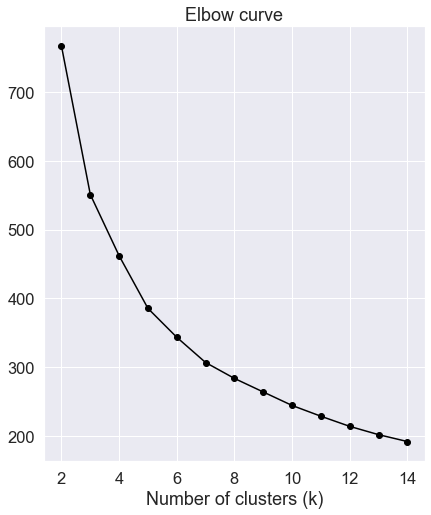

In [210]:
# Specifying the dataset and initializing variables
X = features_norm
distorsions = []

# Calculate SSE for different K
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('Number of clusters (k)')
plt.plot(range(2, 15), distorsions,'-o',color='black')
plt.grid(True)

### Silhouette coefficient

In [211]:
# Generate silhouette coefficient for each k
X = features_norm
silhouette_plot = []
for k in range(2, 15):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

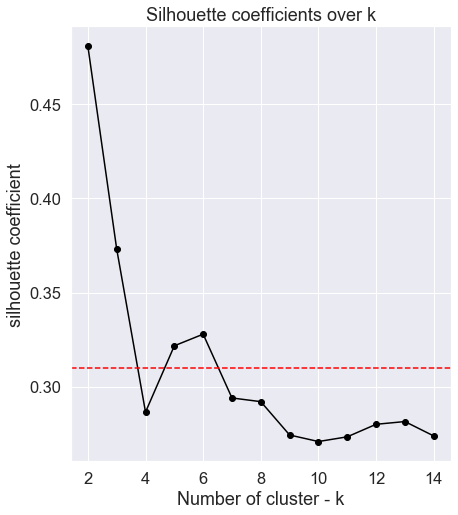

In [212]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('Number of cluster - k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 15), silhouette_plot,'-o',color='black')
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [213]:
model_1 = KMeans(n_clusters=4, random_state=10).fit(features_norm)
model_1.cluster_centers_

array([[ 3.45644292e+01,  6.83067124e+01,  7.03409113e-01,
         7.27085757e-01, -6.50707447e+00,  2.87908329e-01,
         1.41993246e-01,  5.64251277e-03,  2.54140911e-01,
         5.47796423e-01,  1.15259996e+02,  5.07464968e+00,
         5.18439000e+02,  5.38951494e-03,  1.56785889e-02,
         9.46104851e-01,  3.28270456e-02,  2.84174424e-02,
         1.42087212e-02,  9.30426262e-01],
       [ 3.16730011e+01,  6.78673360e+01,  6.99282060e-01,
         7.12812760e-01, -6.69175033e+00,  2.69589136e-01,
         1.36392345e-01,  6.88515747e-03,  2.33723270e-01,
         5.47914569e-01,  1.14868047e+02,  4.17369428e+00,
         3.62225170e+02,  5.37827178e-03,  1.96008127e-02,
         9.46097765e-01,  2.86841162e-02,  2.76084618e-02,
         1.81666069e-02,  9.27692124e-01],
       [ 2.71767607e+01,  6.95419215e+01,  6.51022825e-01,
         6.39270464e-01, -8.05262123e+00,  2.42247958e-01,
         2.22780005e-01,  3.41669108e-02,  2.49154015e-01,
         5.09711048e-01,  1.1

In [214]:
cluster_labels = model_1.fit_predict(features_norm)

In [215]:
len(cluster_labels)

26710

In [216]:
cluster_labels

array([3, 2, 0, ..., 1, 2, 2], dtype=int32)

In [217]:
#Lyrics join
cluster_1_df = pd.concat([features, pd.Series(cluster_labels, name='cluster')], axis=1, join='outer')

In [218]:
cluster_1_df.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,duration_mins,Count_words,timsign_1,timsign_3,timsign_4,timsign_5,lda_1.0,lda_2.0,lda_3.0,cluster
0,24.0,79.0,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,...,4.43,234.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0
1,78.0,79.0,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,...,2.61,165.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
2,57.0,79.0,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,...,4.25,460.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,22.0,78.0,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,...,3.23,317.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,11.0,77.0,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,...,3.35,304.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0


In [219]:
cluster_1_df.cluster.value_counts()

3.0    11235
1.0     8363
2.0     5071
0.0     2041
Name: cluster, dtype: int64

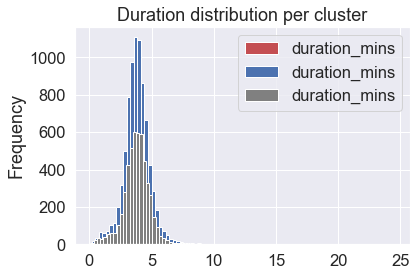

In [230]:
##
cluster_1_df[cluster_1_df['cluster'] == 0]['duration_mins'].plot(kind='hist',color='r',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 1]['duration_mins'].plot(kind='hist',color='b',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 2]['duration_mins'].plot(kind='hist',color='grey',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 3]['duration_mins'].plot(kind='hist',color='black',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 4]['duration_mins'].plot(kind='hist',color='green',bins=50)
plt.title('Duration distribution per cluster')
plt.legend()
plt.show()

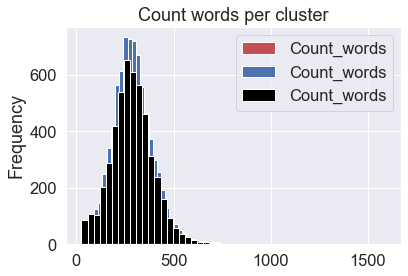

In [235]:
cluster_1_df[cluster_1_df['cluster'] == 0]['Count_words'].plot(kind='hist',color='r',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 1]['Count_words'].plot(kind='hist',color='b',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 2]['Count_words'].plot(kind='hist',color='black',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 3]['Count_words'].plot(kind='hist',color='grey',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 4]['Count_words'].plot(kind='hist',color='green',bins=50)
plt.title('Count words per cluster')
plt.legend()
plt.show()

## Clustering 2 - with TFIDF

### Preparation

In [132]:
print(vect_df.shape)
vect_df.head()

(27110, 1000)


,act,act like,action,ahead,aim,air,album,alive,alone,along,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000,...,0.0,0.0,0.077285,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.093323,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.038533,0.0,0.228883,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.423627,0.0,0.000000,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.053319,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0546,...,0.0,0.0,0.000000,0.0,0.082255,0.0,0.000000,0.0,0.0,0.0


In [133]:
print(df.shape)
df.head()

(27110, 20)


,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,tokens,lemmatized_lyrics,working_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",big # # know Fword go know keep candy need li...
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,317,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,304,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",beat beat y'all beat y'all beat y'all yes y'al...


In [135]:
df.columns

Index(['Artist', 'popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'Year_release',
       'Cleaned_lyrics', 'duration_mins', 'Count_words', 'tokens',
       'lemmatized_lyrics', 'working_lyrics'],
      dtype='object')

In [136]:
#Keep the columns I will use for clustering
df_short = df[['popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature',
       'duration_mins', 'Count_words']]

In [159]:
df_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27110 entries, 0 to 27513
Data columns (total 14 columns):
popularity          27110 non-null int32
num_markets         27110 non-null float64
danceability        27110 non-null float64
energy              27110 non-null float64
loudness            27110 non-null float64
speechiness         27110 non-null float64
acousticness        27110 non-null float64
instrumentalness    27110 non-null float64
liveness            27110 non-null float64
valence             27110 non-null float64
tempo               27110 non-null float64
time_signature      27110 non-null object
duration_mins       27110 non-null float64
Count_words         27110 non-null int64
dtypes: float64(11), int32(1), int64(1), object(1)
memory usage: 4.2+ MB


In [138]:
#quick conversion
df_short['num_markets'] = df_short['num_markets'].astype('float64')

In [139]:
df_short.isna().sum()

popularity          0
num_markets         0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
duration_mins       0
Count_words         0
dtype: int64

In [140]:
#Concat the features with tf-idf
data_tfidf = pd.concat([df_short, vect_df], axis=1)
data_tfidf.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
0,24.0,79.0,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,...,0.0,0.0,0.077285,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,78.0,79.0,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,57.0,79.0,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,...,0.0,0.0,0.000000,0.0,0.038533,0.0,0.228883,0.0,0.0,0.0
3,22.0,78.0,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,11.0,77.0,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,...,0.0,0.0,0.000000,0.0,0.082255,0.0,0.000000,0.0,0.0,0.0


In [141]:
#Checking for null values
data_tfidf.isna().sum()

popularity      400
num_markets     400
danceability    400
energy          400
loudness        400
               ... 
yet             400
york            400
young           400
young nword     400
zone            400
Length: 1014, dtype: int64

In [142]:
#Dropp
data_tfidf.dropna(inplace=True)

In [158]:
data_tfidf.shape

(26710, 1014)

In [236]:
#Scaling data
data_tfidf_norm = pd.DataFrame(norm.fit_transform(data_tfidf),columns=data_tfidf.columns)

In [237]:
data_tfidf_norm.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
0,0.079600,0.262015,0.002438,0.001854,-0.054025,0.000534,0.000006,6.533802e-08,0.000215,0.002942,...,0.0,0.0,0.000256,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.351628,0.356136,0.003354,0.002876,-0.021909,0.000221,0.000037,0.000000e+00,0.000820,0.002164,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.118996,0.164924,0.001511,0.001852,-0.014772,0.000820,0.000280,0.000000e+00,0.000234,0.001555,...,0.0,0.0,0.000000,0.0,0.000080,0.0,0.000478,0.0,0.0,0.0
3,0.064497,0.228671,0.002319,0.002296,-0.030695,0.001220,0.000859,0.000000e+00,0.000865,0.001557,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.033094,0.231656,0.002410,0.001447,-0.041828,0.000698,0.000058,3.219123e-07,0.001188,0.001739,...,0.0,0.0,0.000000,0.0,0.000247,0.0,0.000000,0.0,0.0,0.0


### Let's cluster

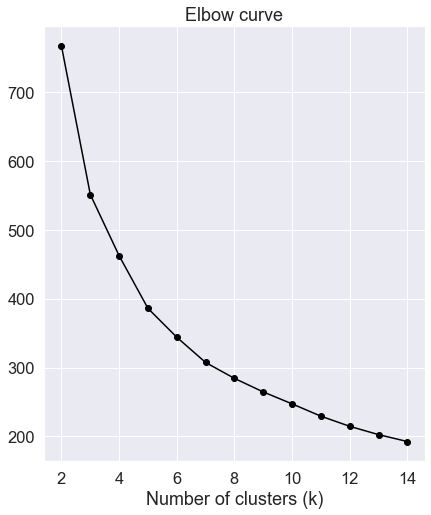

In [238]:
#Elbow
# Specifying the dataset and initializing variables
X = data_tfidf_norm
distorsions = []

# Calculate SSE for different K
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('Number of clusters (k)')
plt.plot(range(2, 15), distorsions,'-o',color='black')
plt.grid(True)

In [239]:
#Silhouette
# Generate silhouette coefficient for each k
X = data_tfidf_norm
silhouette_plot = []
for k in range(2, 15):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

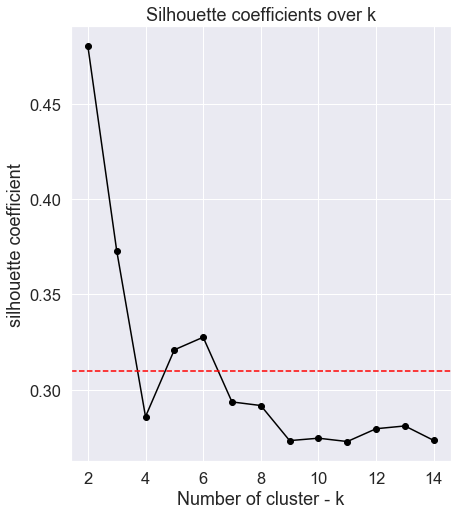

In [240]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('Number of cluster - k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 15), silhouette_plot,'-o',color='black')
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [241]:
model_2 = KMeans(n_clusters=4, random_state=10).fit(data_tfidf_norm)
model_2.cluster_centers_

array([[1.01237558e-01, 2.46839509e-01, 2.31048595e-03, ...,
        4.25135530e-05, 1.39374195e-05, 1.35597523e-05],
       [1.54195398e-01, 4.42151598e-01, 3.70188543e-03, ...,
        6.99390626e-05, 2.22129403e-05, 2.08586875e-05],
       [1.21762873e-01, 2.82442718e-01, 2.71049240e-03, ...,
        5.01523003e-05, 1.77083924e-05, 1.73370736e-05],
       [7.53406054e-02, 1.49529305e-01, 1.81487105e-03, ...,
        3.16441650e-05, 1.02026271e-05, 9.78935312e-06]])

In [242]:
cluster_2_labels = model_2.fit_predict(data_tfidf_norm)

In [243]:
#Lyrics join
cluster_2_df = pd.concat([data_tfidf, pd.Series(cluster_2_labels, name='cluster')], axis=1, join='outer')


In [244]:
cluster_2_df.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,year,years,yellow,yes,yet,york,young,young nword,zone,cluster
0,24.0,79.0,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,...,0.0,0.077285,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2.0
1,78.0,79.0,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2.0
2,57.0,79.0,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,...,0.0,0.000000,0.0,0.038533,0.0,0.228883,0.0,0.0,0.0,3.0
3,22.0,78.0,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,3.0
4,11.0,77.0,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,...,0.0,0.000000,0.0,0.082255,0.0,0.000000,0.0,0.0,0.0,0.0


In [245]:
cluster_2_df.shape

(27108, 1015)

In [246]:
cluster_2_df.cluster.value_counts()

0.0    10201
3.0     9564
2.0     5422
1.0     1523
Name: cluster, dtype: int64

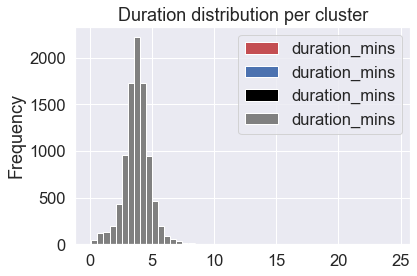

In [247]:
##
cluster_2_df[cluster_2_df['cluster'] == 0]['duration_mins'].plot(kind='hist',color='r',bins=50)
cluster_2_df[cluster_2_df['cluster'] == 1]['duration_mins'].plot(kind='hist',color='b',bins=50)
cluster_2_df[cluster_2_df['cluster'] == 2]['duration_mins'].plot(kind='hist',color='black',bins=50)
cluster_2_df[cluster_2_df['cluster'] == 3]['duration_mins'].plot(kind='hist',color='grey',bins=50)
# cluster_2_df[cluster_2_df['cluster'] == 4]['duration_mins'].plot(kind='hist',color='green',bins=50)
plt.title('Duration distribution per cluster')
plt.legend()
plt.show()

In [ ]:
#PCA for visualization

In [ ]:
cluster_2_df.dropna(inplace=True)

In [252]:
test = cluster_2_df.drop(columns=['cluster'])

In [253]:
len(test)

26312

In [302]:
test.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
0,24.0,79.0,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,...,0.0,0.0,0.077285,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,78.0,79.0,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,57.0,79.0,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,...,0.0,0.0,0.000000,0.0,0.038533,0.0,0.228883,0.0,0.0,0.0
3,22.0,78.0,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,11.0,77.0,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,...,0.0,0.0,0.000000,0.0,0.082255,0.0,0.000000,0.0,0.0,0.0


In [254]:
len(cluster_2_df)

26312

In [373]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_new = pca.fit_transform(test)
x,y = zip(*X_new)
cluster_2_df['x'] = x
cluster_2_df['y'] = y
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_

In [374]:
explained_variance_ratio

array([0.86809752, 0.07049531])

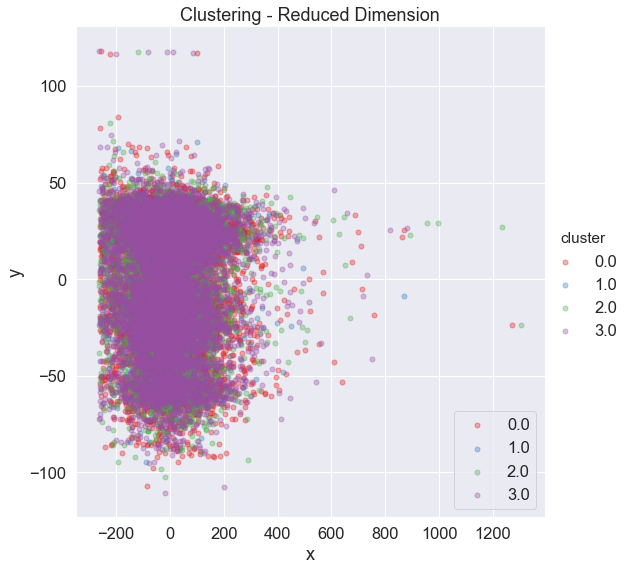

In [256]:
sns.set(font_scale=1.5)
sns.lmplot(data=cluster_2_df, x='x', y='y', hue='cluster', fit_reg=False, legend=True, size=8, palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
plt.legend(loc='lower right')
# plt.ylim(-0.7,1.8)
# plt.xlim(-0.7,1.8)
# plt.savefig('pca_scatter_genres.png')
plt.title("Clustering - Reduced Dimension")
plt.show()

In [257]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

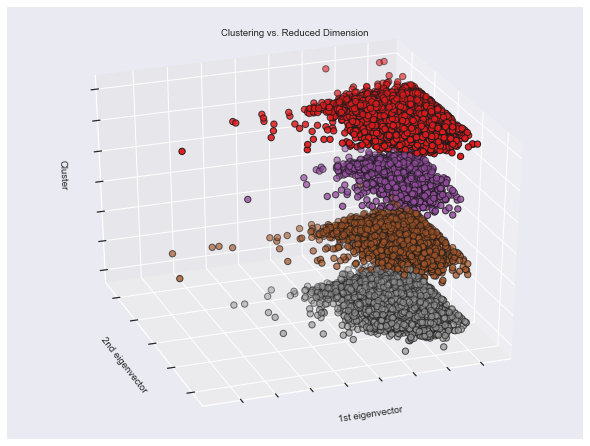

In [375]:
#Visualize top 3 components
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(cluster_2_df['x'], cluster_2_df['y'], cluster_2_df['cluster'], c=cluster_2_df['cluster'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_title('Clustering vs. Reduced Dimension')
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Cluster")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [272]:
cluster_2_df.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,yellow,yes,yet,york,young,young nword,zone,cluster,x,y
0,24.0,79.0,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2.0,-53.624857,-54.102422
1,78.0,79.0,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2.0,-121.345508,14.613957
2,57.0,79.0,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,...,0.0,0.038533,0.0,0.228883,0.0,0.0,0.0,3.0,173.216514,22.566078
3,22.0,78.0,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,3.0,29.560147,20.414168
4,11.0,77.0,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,...,0.0,0.082255,0.0,0.000000,0.0,0.0,0.0,0.0,16.308943,8.292803


In [283]:
list(cluster_2_df.columns)

['popularity',
 'num_markets',
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'duration_mins',
 'Count_words',
 'act',
 'act like',
 'action',
 'ahead',
 'aim',
 'air',
 'album',
 'alive',
 'alone',
 'along',
 'already',
 'alright',
 'always',
 'another',
 'answer',
 'anybody',
 'anything',
 'arm',
 'around',
 'ask',
 'ass',
 'ass nword',
 'attention',
 'away',
 'aye',
 'baby',
 'baby baby',
 'baby girl',
 'back',
 'bad',
 'bad bword',
 'bag',
 'ball',
 'band',
 'bang',
 'bang bang',
 'bank',
 'bar',
 'battle',
 'bear',
 'beat',
 'beautiful',
 'become',
 'bed',
 'beef',
 'begin',
 'behind',
 'believe',
 'bend',
 'benz',
 'best',
 'bet',
 'better',
 'big',
 'bigger',
 'bill',
 'bird',
 'bite',
 'black',
 'blame',
 'blast',
 'blaze',
 'bleed',
 'bless',
 'blind',
 'block',
 'blood',
 'blow',
 'blue',
 'blunt',
 'body',
 'bomb',
 'bone',
 'boo',
 'book',
 'boom',
 'booty',
 'boss',
 'bot

In [303]:
cluster_centers = pd.DataFrame(model_2.cluster_centers_,columns=test.columns)

In [304]:
cluster_centers

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
0,0.101238,0.246840,0.002310,0.002306,-0.022943,0.000816,0.000510,0.000041,0.000760,0.001750,...,0.000029,0.000018,0.000022,0.000009,0.000026,0.000016,0.000015,0.000043,0.000014,0.000014
1,0.154195,0.442152,0.003702,0.003473,-0.059207,0.001783,0.002053,0.000402,0.001729,0.003064,...,0.000050,0.000030,0.000048,0.000022,0.000049,0.000032,0.000028,0.000070,0.000022,0.000021
2,0.121763,0.282443,0.002710,0.002719,-0.029531,0.000937,0.000668,0.000070,0.000932,0.002051,...,0.000034,0.000024,0.000028,0.000011,0.000038,0.000018,0.000019,0.000050,0.000018,0.000017
3,0.075341,0.149529,0.001815,0.001869,-0.017207,0.000707,0.000362,0.000016,0.000620,0.001447,...,0.000022,0.000015,0.000018,0.000008,0.000021,0.000012,0.000012,0.000032,0.000010,0.000010


In [366]:
cluster_summary_c = cluster_centers[['popularity','num_markets',
                'danceability','energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness','liveness',
       'valence','tempo','time_signature','duration_mins','Count_words']]

In [367]:
cluster_summary_c.head(10)

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_mins,Count_words
0,0.101238,0.246840,0.002310,0.002306,-0.022943,0.000816,0.000510,0.000041,0.000760,0.001750,0.371861,0.013282,0.012192,0.881929
1,0.154195,0.442152,0.003702,0.003473,-0.059207,0.001783,0.002053,0.000402,0.001729,0.003064,0.709381,0.023210,0.013698,0.463886
2,0.121763,0.282443,0.002710,0.002719,-0.029531,0.000937,0.000668,0.000070,0.000932,0.002051,0.541709,0.016157,0.013399,0.765495
3,0.075341,0.149529,0.001815,0.001869,-0.017207,0.000707,0.000362,0.000016,0.000620,0.001447,0.256838,0.010369,0.011030,0.944981


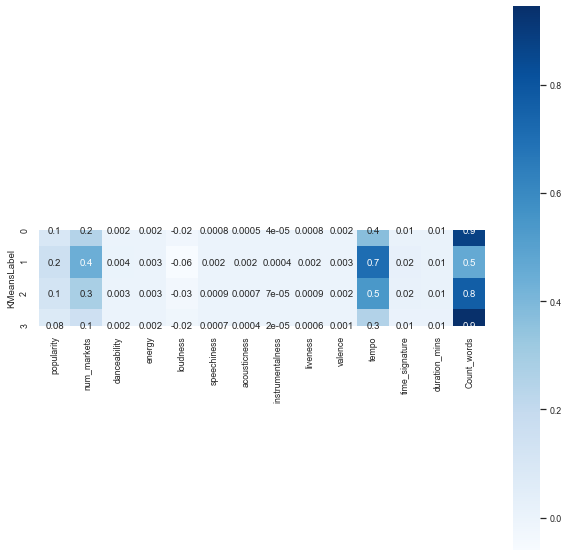

In [368]:
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)

sns.heatmap(
    data=cluster_summary_c,
    annot=True,cmap = "Blues",fmt='.1g',square=True
)
plt.ylabel("KMeansLabel")
plt.show()

In [377]:
test.shape

(26312, 1014)

In [378]:
cluster_2_df.shape

(26312, 1018)